In [ ]:
#!/usr/bin/env python
# coding: utf-8

# 20221129
# 
# sarahfong
# 
# ### intersect nullomers, empirical shuffle with phylop 100way bigWig
# 
# split by exonic/non-exonic
# 
# 
# use bigWigSummary executable from UCSC to get phylop 
# 
# 
# compare nullomers v. empirical background

# In[ ]:
—

In [6]:
import glob
from joblib import Parallel, delayed
import os
import pybedtools as pbt
import subprocess
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels as sm

# append path
sys.path.append("/wynton/home/ahituv/fongsl/tools/py_/")

# import config reader
import config_readwrite as crw
import zippery

#config_tag, NBASES, ARRAY_IND = sys.argv[1], sys.argv[2], sys.argv[3]

#NBASES = int(NBASES)

config_tag, NBASES, ARRAY_IND = "config-exon.ini", "500", "3"
print(ARRAY_IND, type(ARRAY_IND), config_tag, NBASES, type(NBASES))

# append path
sys.path.append("/wynton/home/ahituv/fongsl/tools/py_/")

# import config reader
import config_readwrite as crw
import count_lines as cl
import plot_params as pp

config_name = os.path.join(os.getcwd(), config_tag)

config, configname = crw.read_config(config_name)


# select config variables
ANNOT = config["GENCODE"]["ANNOT"]  
DATA_PATH = config["DATA"]["PATH"]

# get QSUB array
ARRAY = config["QSUB"]["ARRAY"]  # tab separated file. 

# phylop files, wiggle track executables
PHYLOP_BW = config["PHYLOP"]["100WAY_BW"]

PHYLOP_BW = "/wynton/group/databases/goldenPath/hg38/phyloP100way/hg38.phyloP100way.bw"
PHYLOP_PATH = os.path.join(DATA_PATH, "phylop")
SRC_BW = "/wynton/home/ahituv/fongsl/nullomers/src/bigWigSummary"

config["PHYLOP"]["100WAY_BW"] = PHYLOP_BW
config["PHYLOP"]["PATH"] = PHYLOP_PATH
config["PHYLOP"]["FLANK_BP"]= str(NBASES)

crw.check_section(config, "SRC")
config["SRC"]["bigwigsummary"] = SRC_BW

3 <class 'str'> config-exon.ini 500 <class 'str'>


In [7]:
# # functions
def getArrayMatch(arrayfile, array_ind):

 
    ### return .bed file from array file. 
    with open(arrayfile, "r") as array:
        for line in array.readlines():

            JOB_NUM, BEDFILE = (line.strip("\n")).split("\t")
            if str(JOB_NUM) == str(array_ind):  # get the number corresponding to the file. 
                print("match array",JOB_NUM, BEDFILE)
                RETURN_BED = BEDFILE
                
    return RETURN_BED
    

def expand_bedcoor(bedfile, nbases):
    """
    write expanded bedcoordinates file. 
    
    inputs
        bedfile (str) - full path to bed file to expand
        nbases (int) - number of bases to expand by IN EACH DIRECTION
        
    method
        
        1. build outfile str
        2. make pybedtool object (if outfile does not exist, else skip)
        3. use bedtools slop to expand bed coordinates, save output
        4. unit test expansion
        
    returns
    
        outbed (str) - full path to expanded coordinate bedfile
    """
    
    #1
    out = bedfile.strip(".bed") + f"-EXPANDED-{nbases}.bed"
    
    if os.path.exists(out) is False:
        #2
        bed = pbt.BedTool(bedfile)

        #3
        expanded = bed.slop(genome="hg38", b=nbases, output=out)
        
    else:
        print("expanded", nbases, " in either direction, already")

    #4
    with open(bedfile, "r") as file:
        for line in file:
            print("original", line)
            break  # only print the first original line in the file
            
    with open(out, "r") as ex:
        for line in ex:
            print("expanded", line) 
            break  # only print he first expanded line in the file
    
    return out

# ## parse bigwig for bed coordinates


def getBwBedLineSummary(bw, bed_line_list, nbases, outfile, src):
    
    """
    write bed coordinates + phylop values for a bed-coordinate region. 
    
    input
        bw (str) - path to bigwig file to parse
        bed_line_list (list) - list with CHR, START, STOP, and 4th column annotations. 
            Should correspond to 1 .bed line.
        nsteps (int) - steps to summarize the phylop sequence in. 
            e.g. If 1000 bases in sequences and nsteps == 1000, will return each bp phylop score. 
            e.g. if 1000 bases in sequences and nsteps == 10, will average (?) 100bp phylop scores into 1 output. 
        outfile (str) - full path to write file. 
        src (str) - path to ./bigWigSummary executable. 
        
    method
        1. unpack bed_line_list into CHR, START, STOP, and sample ID variables
        2. run bigWigSummary command, get phyloP scores for the bed coordinates (output). 
        3. make new line (str) w/ bedcoordinates, id, phylop results
        4. write bed coordinates and phylop to the outfile
        
        
    """
    
    #1
    chr_, start_, end_, nid = bed_line_list
    nsteps = int(nbases)*2
    
    # TO DO: insert a check for existing file, number of lines in file. Concerned about parallelized runs and writing to wrong coordinates. 
    
    #2              
    cmd = f"{src} {bw} {chr_} {str(start_)} {str(end_)} {str(nsteps)}"
    print(cmd, "\n")
 
    result = subprocess.run([src, bw, chr_, str(start_), str(end_), str(nsteps)], stdout=subprocess.PIPE)
 
    #3 make a str (tab-delimited) of the bed coordinates and phylop results
    newline = "\t".join(bed_line_list) +"\t"+ result.stdout.decode('utf-8') +"\n"
    print(newline)
    
    #4 
    with open(outfile, "a") as writer:
        writer.write(newline)
        writer.close()

# get summary stats for phylop scores

def getSummaryStats(phylop_file):
    
    """
    return summary stats for each position in a phylop window
    
    input
        phylop_file (str) - path to phylop bw extracted file from above run
        
    method
        1. make a pandas dataframe out of the dictionary
            
            col 0-3 = CHR, START, STOP, Nullomer ID
            col 4-1003 = each bp position phylop score flanking nullomer
            
            col 503 = nullomer. 

        2. filter
            2.1 remove any lines w/ no data 
            2.2 replace "n/a" str value
        
        3. turn dataframe into long form data, where 1 column is the position, and another column is the phylop value
            index on CHR, START, STOP, Nullomer ID
        
        4. compute summary stats per position across nullomer sequence for phylop scores.
            4.1 also correct for
        
        5. write summary stats to outfile
    
    return 
    
        summary stats outfile (str) - write summary stats as file, 
            ## so that stats can be done on empirical summary statistics. 
            
        
    """
    out = phylop_file.strip(".txt") + "-SUMMARY_STATS.txt"

    #1 make a pandas dataframe
    df = pd.read_csv(phylop_file, sep = '\t', header = None, low_memory = False)
    

    #2
    df = df.loc[df[4] != "no"] ## there are some cases where there is no data. 
    df = df.replace("n/a", None)
    print(df.shape)
    print(df.head())

    
    #3
    melted = pd.melt(df, id_vars= df.columns[:4], var_name="pos", value_name="phylop")
    print(melted.head())
    
    melted["phylop"] = melted["phylop"].astype(float)  # change data type
    
    #4
    summary_stats = melted.groupby("pos")["phylop"].describe().reset_index()
    
    summary_stats["pos"] = summary_stats["pos"] - 4 # correct bp position 
    
    #5 
    summary_stats.to_csv(out, sep ='\t', index=False)
    
    zippery.rezip_file(phylop_file)
    
    return out

In [23]:
# # Main 

# ## exonic, non-exonic; expand; extract bw values

def main(argv):
    

    
    # combined function that expands mutations and extracts phylop scores
    #out = expandAndBwExtract(BED, NBASES, PHYLOP_BW, PHYLOP_PATH)
    """
    extract and summarize phylop for expanded bed coordinates. 
    
    inputs
        BED (str) - bed file name w/ full path from ARRAY
        PHYLOP_PATH (str) - full path to output file directory
        NBASES (int) - number of bases to expand on each side
        PHYLOP_BW (str) - full path to phylop bigWig file. 
        
        
    method
    0. makes an outfile. 
        0.1 if scores have not been extracted already
        0.2 if scores have been and the file is zipped
    1. takes locus and expands the bed coordinates of the locus. 
    2. extracts the phylop base scores for the expanded locus, writing the scores as a vector
    3. write summary stats of file. (Summary stats at each bp)


    return 
        outfile (str) - name to output values. 
    """
    
    BED = getArrayMatch(ARRAY, ARRAY_IND)
    
    

    #0 make the outfile
    name = (BED.split("/")[-1]).strip(".bed") + "-phylop.txt"
    outfile = os.path.join(PHYLOP_PATH, name)
    

    #1 expand bed coordinates
    print("expanding", BED, "n bases", NBASES)
    
    outex = expand_bedcoor(BED, int(NBASES))
    
    print("EXPANDED", outex)

    #2 get phylop values from bigwig and write to the outfile. 
    with open(outex, "r") as ex:
    
        print("reading expanded file", outex)
        
        for line in ex.readlines():
            bedlist = (line.strip("\n")).split("\t")
            getBwBedLineSummary(PHYLOP_BW, bedlist, NBASES, outfile, SRC_BW)

    print("wrote phylop scores to", outfile)

    # 3
    summary_outfile = getSummaryStats(outfile)

    print(summary_outfile)
    
    # # write config

    crw.write_config(config, configname)

if __name__ == "__main__":
    main(sys.argv[1:])

3 <class 'str'> config-exon.ini 500 <class 'str'>


# Analysis

In [67]:
RE_PATH = config["RESULTS"]["PATH"] 
ANNOT = config["GENCODE"]["ANNOT"] 
RE = os.path.join(RE_PATH,"PHYLOP")
os.mkdir(RE)
config["RESULTS"]["PHYLOP"] = RE 

In [103]:
def plot_line(coding_stats, shuf_coding_stats, out_pdf,datatype, xrange):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.lineplot(coding_stats, x="pos", y= '50%',  label = "50%" )
    sns.lineplot(coding_stats, x="pos", y= '25%', color = "y", label = "25%")
    sns.lineplot(coding_stats, x="pos", y= '75%', color = "g", label = "75%")

    sns.lineplot(shuf_coding_stats, x="pos", y= '50%', label = "shuf-50%", ls = "--")
    sns.lineplot(shuf_coding_stats, x="pos", y= '25%',  label = "shuf-25%", ls = "--")
    sns.lineplot(shuf_coding_stats, x="pos", y= '75%',  label = "shuf-75%", ls = "--")
    
    ax.axvline(499, color="k", ls = "--") # center line
    
    ax.set(xlim = (xrange[0], xrange[1]),
           ylabel = "phylop score - 100way",
            title = f"{datatype}:{xrange[0]}-{xrange[1]}")
    
    ax.legend(loc="upper right")
    
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    
def calculateEmpiricalP(obs, exp_sum_list):
    
    import datetime
    """
    return two lists
        (1) info - vector w/  
                n_obs, 
                median_exp, 
                std, 
                fold-change  # calculated from the median of expected shuffle 
                p_val
                
        (2) fold_changes- vector expected fold changes (to calculate confidence interval)
        
    input
        observed overlap count (int)
        list of expected overlap counts (list of ints)
    
    method
        1. get median of expected overlap counts
        2. get standard deviation of expected overlap counts
        3. center expected overlap counts at median
        4. Sum the number of centered expected counts greater than observed centered count
            This is two tailed because it evaluates both sides of the distribution (w/ abs value). 
        5. calculate fold change as observed/ median expected w/ pseudo count
        6. calculate fold change of each "obs"/ expected w/ pseudo count
        7. calculate the p-value as count of equal or more extreme values than observed value
        8. return list of empirical info + fold changes
        
        
    
    """
    #1
    mu = np.median(exp_sum_list)  # median of exp.dist
    
    #2
    sigma = np.std(exp_sum_list)  # std
    
    #3
    dist_from_mu = [exp - mu for exp in exp_sum_list] # center the distribution 
    
    #4
    p_sum = sum(1 for exp_dist in dist_from_mu if abs(exp_dist) >= abs(obs - mu)) # count values >= centered obs

    #5
    fold_change = (obs + 1.0) / (mu + 1.0) # fold change obs from median expected w pseudo count
    
    #6
    fold_changes = list((obs + 1.0) / (m + 1.0) for m in exp_sum_list) # fold change obs from /each exp w pseudo count
    
    #7
    p_val = (p_sum + 1.0) / (len(exp_sum_list) + 1.0)  # probability of observing obs-like value equal or more extreme in expected distribution
    
    #8
    info = [
            obs, 
            mu, 
            sigma, 
            fold_change, 
            p_val, 
            str(datetime.datetime.now())
            ]
    
    return info, fold_changes

def exp(nullo, shuf, summary_stat_name, pos):
    """
    return PER POSITION foldchange, empirical P between observed and expected (shuffled) data
    
    input
        nullo (df) - pandas dataframe of nullomer summary stats in long form (each row is one base in dist)
        shuf (df) - pandas dataframe of N shuffled summary stats in long form (each row is one base in dist)
        summary_stat_name (str) - summary_stat measurement name (this should be a column in the dataframes)
        pos (int) - relative position of the base to estimate fold change between. 
        
    method
        1. prepare position phylop vectors for obs, exp
        2. calculate empirical P
    
    
    """
    obs = nullo.loc[nullo["pos"]== pos, summary_stat_name].iloc[0]
    exp_list =  shuf.loc[shuf["pos"]== pos, summary_stat_name].to_list()
    
    info, fold_changes = calculateEmpiricalP(obs, exp_list)
    
    print(info)
    
    return info, fold_changes

## coding 

In [105]:
DATATYPE = 'OVERLAP'
file_list = glob.glob(os.path.join(PHYLOP_PATH, "*-exon_overlap*SUMMARY_STATS.txt"))
print(len(file_list))

df_list = []

for f in file_list:
    
    # assign static label
    if "shuf" in f:
        LABEL = "SHUF"
    else:
        LABEL = "NULLO"
    ID = f.split("/")[-1]
    
    df = pd.read_csv(f, sep='\t')
    df["label"] = LABEL
    df["id"] = ID
    
    df_list.append(df)    

df = pd.concat(df_list)

nullo = df.loc[df["label"] == "NULLO"]
shuf = df.loc[df["label"] != "NULLO"]

501


<AxesSubplot:xlabel='pos', ylabel='50%'>

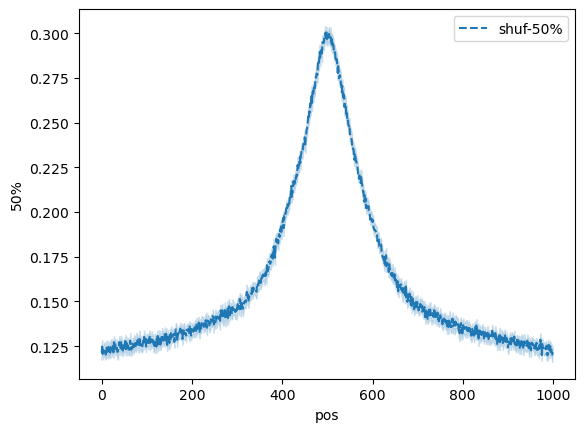

In [35]:
sns.lineplot(shuf, x="pos", y= '50%', label = "shuf-50%", ls = "--")

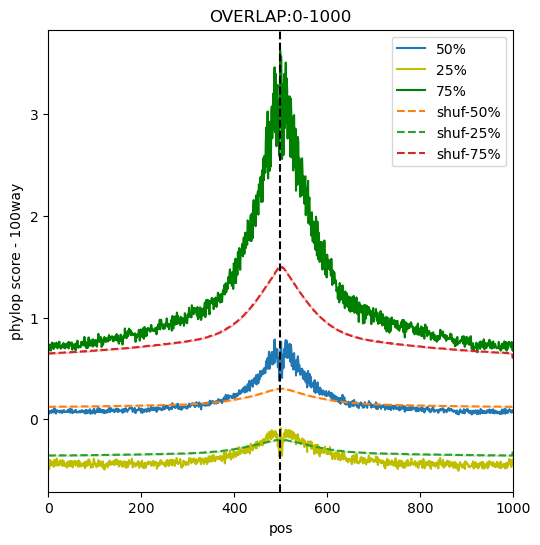

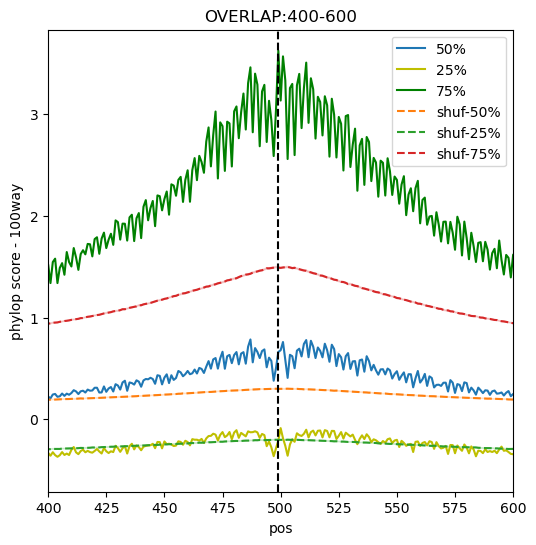

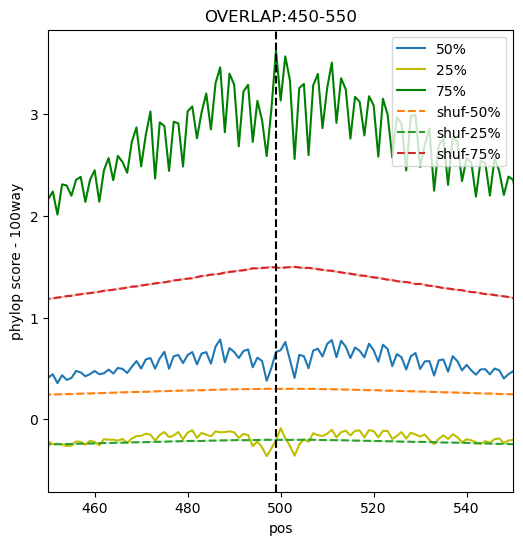

In [106]:
out = os.path.join(RE, f"phylop-1kb_{ANNOT}_{DATATYPE}.pdf")
X = [0,1000]
plot_line(nullo, shuf, out, DATATYPE, X)
out = os.path.join(RE, f"phylop-0.2kb_{ANNOT}_{DATATYPE}.pdf")
X = [400,600]
plot_line(nullo, shuf, out, DATATYPE, X)

out = os.path.join(RE, f"phylop-0.1kb_{ANNOT}_{DATATYPE}.pdf")
X = [450,550]
plot_line(nullo, shuf, out, DATATYPE, X)

In [107]:
# MIDPOINT - median summary stats 
i, f = exp(nullo, shuf, "50%", 500)

# MIDPOINT-100 - median summary stats 
i, f = exp(nullo, shuf, "50%", 400)

# MIDPOINT+100 - median summary stats 
i, f = exp(nullo, shuf, "50%", 600)

## non-coding 

[0.679, 0.302, 0.01377883431208896, 1.2895545314900154, 0.001996007984031936, '2022-12-13 21:45:40.097446']
[0.223, 0.193, 0.011296389644483764, 1.025146689019279, 0.00998003992015968, '2022-12-13 21:45:40.100580']
[0.249, 0.195, 0.012623837570247804, 1.0451882845188285, 0.001996007984031936, '2022-12-13 21:45:40.103334']


### empirical P for median phylop

In [90]:
# MIDPOINT - median summary stats 

lines = []
for pos in np.arange(0,1000):
    """
    
    """
    i, f = exp(nullo, shuf, "50%", pos)
    
    i.extend([pos,f"{ANNOT}-{DATATYPE}", "50%\n"])
    i = [str(item) for item in i]
    line = "\t".join(i)
    lines.append(line)


[0.092, 0.1225, 0.01274290327986523, 0.9728285077951002, 0.021956087824351298, '2022-12-13 19:22:47.115548']
[0.081, 0.124, 0.011638309971812918, 0.9617437722419927, 0.001996007984031936, '2022-12-13 19:22:47.118616']
[0.053, 0.124, 0.011813709789900885, 0.936832740213523, 0.001996007984031936, '2022-12-13 19:22:47.121540']
[0.077, 0.124, 0.012264503414325426, 0.9581850533807827, 0.001996007984031936, '2022-12-13 19:22:47.124333']
[0.082, 0.123, 0.012181074295808232, 0.9634906500445236, 0.003992015968063872, '2022-12-13 19:22:47.127133']
[0.0715, 0.123, 0.012140366716042808, 0.954140694568121, 0.001996007984031936, '2022-12-13 19:22:47.129998']
[0.07, 0.123, 0.012429005551531468, 0.9528049866429208, 0.001996007984031936, '2022-12-13 19:22:47.132673']
[0.063, 0.123, 0.012204413300114021, 0.9465716829919857, 0.001996007984031936, '2022-12-13 19:22:47.135301']
[0.0885, 0.123, 0.01192515404512663, 0.9692787177203919, 0.003992015968063872, '2022-12-13 19:22:47.137877']
[0.0825, 0.123, 0.011

[0.077, 0.129, 0.012721962270027372, 0.953941541186891, 0.001996007984031936, '2022-12-13 19:22:47.318772']
[0.101, 0.127, 0.01194729304068499, 0.9769299023957408, 0.029940119760479042, '2022-12-13 19:22:47.320534']
[0.0895, 0.129, 0.012624888751985103, 0.9650132860938884, 0.001996007984031936, '2022-12-13 19:22:47.322200']
[0.069, 0.128, 0.011999928499786988, 0.9476950354609928, 0.001996007984031936, '2022-12-13 19:22:47.323824']
[0.084, 0.128, 0.011874631573232073, 0.9609929078014184, 0.001996007984031936, '2022-12-13 19:22:47.325428']
[0.068, 0.129, 0.01160357944773939, 0.945969884853853, 0.001996007984031936, '2022-12-13 19:22:47.327039']
[0.0925, 0.1285, 0.012198970243426288, 0.9680992467877714, 0.00998003992015968, '2022-12-13 19:22:47.328635']
[0.081, 0.131, 0.01175561529652957, 0.9557913351016799, 0.001996007984031936, '2022-12-13 19:22:47.330257']
[0.0635, 0.129, 0.012602336092963084, 0.9419840566873339, 0.001996007984031936, '2022-12-13 19:22:47.331870']
[0.091, 0.129, 0.0123

[0.0945, 0.139, 0.01240720641401601, 0.9609306409130817, 0.001996007984031936, '2022-12-13 19:22:47.522281']
[0.1, 0.138, 0.011751068036565867, 0.9666080843585239, 0.003992015968063872, '2022-12-13 19:22:47.523984']
[0.1105, 0.138, 0.011747140034919137, 0.975834797891037, 0.023952095808383235, '2022-12-13 19:22:47.525586']
[0.107, 0.13875, 0.01189670454369612, 0.9721185510428102, 0.005988023952095809, '2022-12-13 19:22:47.527196']
[0.11, 0.138, 0.011786479542255184, 0.975395430579965, 0.02594810379241517, '2022-12-13 19:22:47.528802']
[0.096, 0.14, 0.011834817953817455, 0.9614035087719298, 0.001996007984031936, '2022-12-13 19:22:47.530420']
[0.0985, 0.13825, 0.012094898883413616, 0.9650779705688557, 0.001996007984031936, '2022-12-13 19:22:47.532026']
[0.093, 0.138, 0.012210626355760786, 0.960456942003515, 0.001996007984031936, '2022-12-13 19:22:47.533633']
[0.099, 0.13825, 0.011886566998086536, 0.9655172413793104, 0.003992015968063872, '2022-12-13 19:22:47.535246']
[0.0925, 0.14, 0.012

[0.155, 0.16675, 0.013761113472390235, 0.9899292907649454, 0.3932135728542914, '2022-12-13 19:22:47.724850']
[0.178, 0.166, 0.013082578339150124, 1.0102915951972555, 0.4031936127744511, '2022-12-13 19:22:47.726654']
[0.169, 0.167, 0.01299472985482961, 1.0017137960582692, 0.908183632734531, '2022-12-13 19:22:47.728234']
[0.16, 0.167, 0.012855687301735369, 0.9940017137960582, 0.5808383233532934, '2022-12-13 19:22:47.729810']
[0.198, 0.1695, 0.013159073333635618, 1.0243693886276186, 0.031936127744510975, '2022-12-13 19:22:47.731355']
[0.171, 0.1695, 0.012930290754658225, 1.0012825994014536, 0.9341317365269461, '2022-12-13 19:22:47.732937']
[0.176, 0.169, 0.013085662535767914, 1.0059880239520957, 0.6127744510978044, '2022-12-13 19:22:47.734508']
[0.175, 0.169, 0.012815669276319516, 1.0051325919589393, 0.6387225548902196, '2022-12-13 19:22:47.736082']
[0.191, 0.171, 0.012712631513577351, 1.0170794192997439, 0.1497005988023952, '2022-12-13 19:22:47.737634']
[0.179, 0.171, 0.01325915423396228

[0.585, 0.302, 0.013388531323487277, 1.217357910906298, 0.001996007984031936, '2022-12-13 19:22:47.928309']
[0.407, 0.3035, 0.013189752802839032, 1.0794016110471807, 0.001996007984031936, '2022-12-13 19:22:47.929945']
[0.634, 0.301, 0.012637969575845643, 1.255956956187548, 0.001996007984031936, '2022-12-13 19:22:47.931322']
[0.62, 0.301, 0.013164039805470052, 1.2451960030745581, 0.001996007984031936, '2022-12-13 19:22:47.932701']
[0.502, 0.3015, 0.013902467263043637, 1.1540530157510567, 0.001996007984031936, '2022-12-13 19:22:47.934113']
[0.675, 0.302, 0.013534339141605697, 1.2864823348694316, 0.001996007984031936, '2022-12-13 19:22:47.935511']
[0.694, 0.299, 0.01356440651116001, 1.3040800615858352, 0.001996007984031936, '2022-12-13 19:22:47.936848']
[0.618, 0.298, 0.014655963803175825, 1.24653312788906, 0.001996007984031936, '2022-12-13 19:22:47.938194']
[0.741, 0.296, 0.013583880299825964, 1.3433641975308643, 0.001996007984031936, '2022-12-13 19:22:47.939571']
[0.779, 0.29625, 0.0132

[0.1215, 0.164, 0.012711149869307653, 0.9634879725085911, 0.001996007984031936, '2022-12-13 19:22:48.131128']
[0.151, 0.163, 0.012721496570765564, 0.9896818572656921, 0.3972055888223553, '2022-12-13 19:22:48.132623']
[0.1495, 0.163, 0.013110832772940093, 0.9883920894239037, 0.3193612774451098, '2022-12-13 19:22:48.134038']
[0.1225, 0.163, 0.01327115891698988, 0.9651762682717111, 0.005988023952095809, '2022-12-13 19:22:48.135450']
[0.17, 0.162, 0.012518095542054311, 1.0068846815834769, 0.5369261477045908, '2022-12-13 19:22:48.136829']
[0.166, 0.1605, 0.012629888993969822, 1.004739336492891, 0.6506986027944112, '2022-12-13 19:22:48.138282']
[0.149, 0.162, 0.013440250704506966, 0.9888123924268504, 0.34530938123752497, '2022-12-13 19:22:48.139676']
[0.178, 0.161, 0.012264211796931754, 1.0146425495262703, 0.17764471057884232, '2022-12-13 19:22:48.141100']
[0.1555, 0.16, 0.01284158697357924, 0.9961206896551724, 0.7385229540918163, '2022-12-13 19:22:48.142478']
[0.129, 0.16, 0.012623502643878

[0.0785, 0.136, 0.0119694809828998, 0.9493838028169013, 0.001996007984031936, '2022-12-13 19:22:48.333584']
[0.1005, 0.136, 0.012179056244225165, 0.9687499999999999, 0.011976047904191617, '2022-12-13 19:22:48.335050']
[0.1135, 0.13625, 0.012159687660462335, 0.9799779977997799, 0.07385229540918163, '2022-12-13 19:22:48.336423']
[0.096, 0.136, 0.011798740441250496, 0.9647887323943661, 0.003992015968063872, '2022-12-13 19:22:48.337707']
[0.08, 0.13575, 0.012328133840934724, 0.9509134932863746, 0.001996007984031936, '2022-12-13 19:22:48.339024']
[0.093, 0.136, 0.01201170678962819, 0.9621478873239435, 0.001996007984031936, '2022-12-13 19:22:48.340339']
[0.105, 0.13575, 0.01251815545517789, 0.9729253797050407, 0.011976047904191617, '2022-12-13 19:22:48.341710']
[0.103, 0.135, 0.012286215853549047, 0.971806167400881, 0.005988023952095809, '2022-12-13 19:22:48.343032']
[0.099, 0.136, 0.012570104056848533, 0.9674295774647886, 0.007984031936127744, '2022-12-13 19:22:48.344302']
[0.111, 0.135, 0.

[0.06, 0.1265, 0.012166425111757358, 0.9409675987572126, 0.001996007984031936, '2022-12-13 19:22:48.536597']
[0.072, 0.128, 0.012400424025008178, 0.9503546099290779, 0.001996007984031936, '2022-12-13 19:22:48.538366']
[0.084, 0.127, 0.011586983041327022, 0.9618456078083408, 0.001996007984031936, '2022-12-13 19:22:48.539874']
[0.069, 0.127, 0.012284735691092423, 0.9485359361135758, 0.001996007984031936, '2022-12-13 19:22:48.541382']
[0.047, 0.127, 0.011491991298291173, 0.9290150842945873, 0.001996007984031936, '2022-12-13 19:22:48.542886']
[0.067, 0.126, 0.012054238424720162, 0.9476021314387212, 0.001996007984031936, '2022-12-13 19:22:48.544386']
[0.058, 0.1265, 0.01246322125295062, 0.9391921881935198, 0.001996007984031936, '2022-12-13 19:22:48.545896']
[0.085, 0.127, 0.011737964857674435, 0.9627329192546583, 0.001996007984031936, '2022-12-13 19:22:48.547397']
[0.059, 0.126, 0.012538935202001803, 0.9404973357015987, 0.001996007984031936, '2022-12-13 19:22:48.548904']
[0.065, 0.126, 0.01

## noncoding

In [91]:
DATATYPE = "NOOVERLAP"
file_list = glob.glob(os.path.join(PHYLOP_PATH, "*-exon_no-overlap*SUMMARY_STATS.txt"))
print(len(file_list))

df_list = []

for f in file_list:
    
    # assign static label
    if "shuf" in f:
        LABEL = "SHUF"
    else:
        LABEL = "NULLO"
    ID = f.split("/")[-1]
    
    df = pd.read_csv(f, sep='\t')
    df["label"] = LABEL
    df["id"] = ID
    
    df_list.append(df)    

df = pd.concat(df_list)

nullo = df.loc[df["label"] == "NULLO"]
shuf = df.loc[df["label"] != "NULLO"]

497


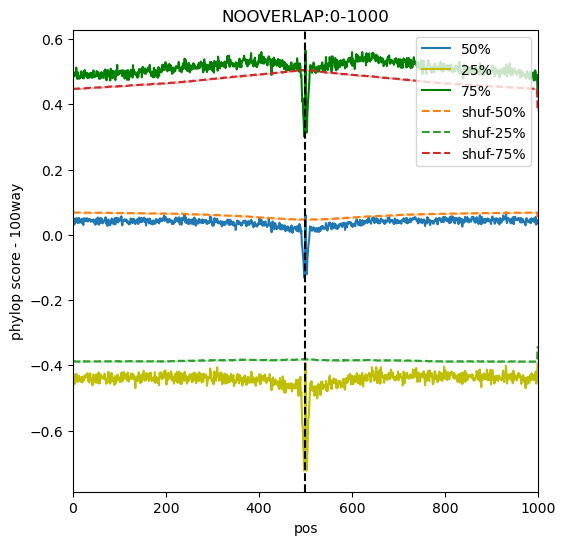

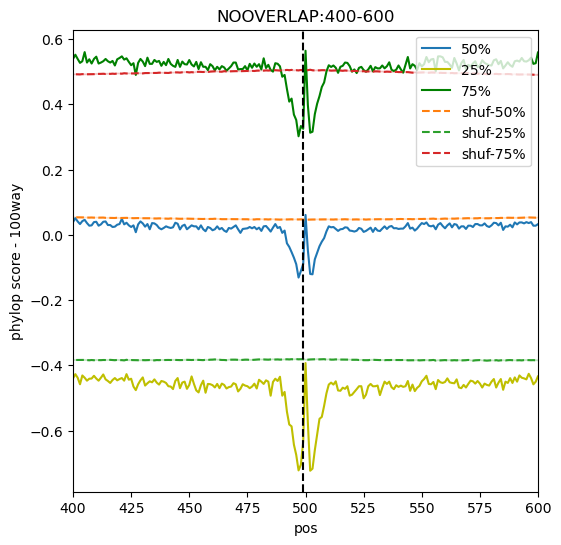

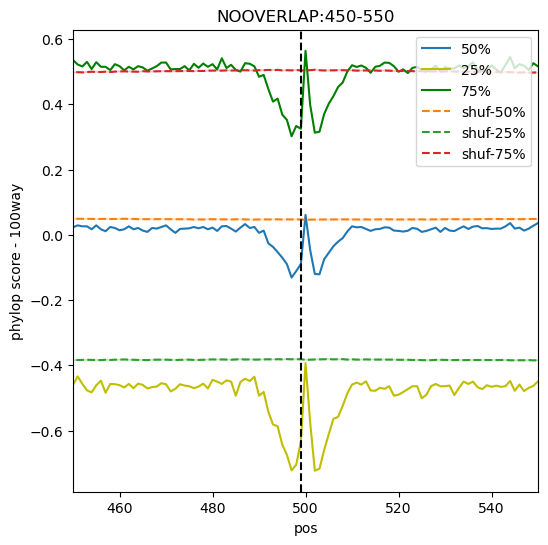

In [104]:
out = os.path.join(RE, f"phylop-1kb_{ANNOT}_{DATATYPE}.pdf")
X = [0,1000]
plot_line(nullo, shuf, out, DATATYPE, X)
out = os.path.join(RE, f"phylop-0.2kb_{ANNOT}_{DATATYPE}.pdf")
X = [400,600]
plot_line(nullo, shuf, out, DATATYPE, X)

out = os.path.join(RE, f"phylop-0.1kb_{ANNOT}_{DATATYPE}.pdf")
X = [450,550]
plot_line(nullo, shuf, out, DATATYPE, X)

In [59]:
# MIDPOINT - median summary stats 
i, f = exp(nullo, shuf, "50%", 500)

# MIDPOINT-100 - median summary stats 
i, f = exp(nullo, shuf, "50%", 400)

# MIDPOINT+100 - median summary stats 
i, f = exp(nullo, shuf, "50%", 600)

## non-coding 

[0.061, 0.042, 0.0, 1.0182341650671785, 0.5, '2022-12-13 14:44:26.530008']
[0.039, 0.055, 0.0, 0.9848341232227488, 0.5, '2022-12-13 14:44:26.532053']
[0.033, 0.047, 0.0, 0.9866284622731614, 0.5, '2022-12-13 14:44:26.533889']


In [96]:
for pos in np.arange(0,1000):
    """
    quantify empirical p-value for each position along window
    
    write as a str, append to lines list
    
    """
    i, f = exp(nullo, shuf, "50%", pos)
    
    i.extend([pos,f"{ANNOT}-{DATATYPE}", "50%\n"])
    i = [str(item) for item in i]
    line = "\t".join(i)
    lines.append(line)

[0.046, 0.068, 0.006122406953393874, 0.9794007490636704, 0.004024144869215292, '2022-12-13 19:33:49.860259']
[0.051, 0.06825, 0.006415222153570101, 0.9838520945471566, 0.004024144869215292, '2022-12-13 19:33:49.863826']
[0.048, 0.069, 0.006171481290706474, 0.9803554724041161, 0.002012072434607646, '2022-12-13 19:33:49.867177']
[0.032, 0.068, 0.006230622927987186, 0.9662921348314606, 0.002012072434607646, '2022-12-13 19:33:49.871061']
[0.043, 0.068, 0.006074087116479496, 0.9765917602996254, 0.002012072434607646, '2022-12-13 19:33:49.874919']
[0.049, 0.068, 0.006458870586995868, 0.9822097378277153, 0.006036217303822937, '2022-12-13 19:33:49.878741']
[0.043, 0.068, 0.006176816592339505, 0.9765917602996254, 0.002012072434607646, '2022-12-13 19:33:49.882616']
[0.051, 0.068, 0.0061561514541783316, 0.9840823970037452, 0.01006036217303823, '2022-12-13 19:33:49.886198']
[0.04, 0.068, 0.006227660061163337, 0.9737827715355805, 0.002012072434607646, '2022-12-13 19:33:49.889704']
[0.039, 0.068, 0.0

[0.0455, 0.067, 0.006197084709390085, 0.9798500468603563, 0.002012072434607646, '2022-12-13 19:33:50.064591']
[0.0345, 0.067, 0.006264257200467444, 0.9695407685098407, 0.002012072434607646, '2022-12-13 19:33:50.066866']
[0.0465, 0.067, 0.006289385527806173, 0.9807872539831303, 0.002012072434607646, '2022-12-13 19:33:50.068740']
[0.04, 0.067, 0.006355141169807038, 0.9746954076850984, 0.002012072434607646, '2022-12-13 19:33:50.070409']
[0.0335, 0.066, 0.006334908336354032, 0.9695121951219512, 0.002012072434607646, '2022-12-13 19:33:50.072064']
[0.035, 0.066, 0.006281282841688622, 0.970919324577861, 0.002012072434607646, '2022-12-13 19:33:50.073708']
[0.051, 0.067, 0.00602063492022327, 0.9850046860356139, 0.01006036217303823, '2022-12-13 19:33:50.075367']
[0.032, 0.066, 0.006049894973331807, 0.9681050656660413, 0.002012072434607646, '2022-12-13 19:33:50.077028']
[0.052, 0.066, 0.006008021216557546, 0.9868667917448405, 0.022132796780684104, '2022-12-13 19:33:50.078673']
[0.041, 0.067, 0.00

[0.047, 0.064, 0.005992132124454306, 0.9840225563909774, 0.01006036217303823, '2022-12-13 19:33:50.268363']
[0.049, 0.064, 0.006074778443907221, 0.9859022556390976, 0.014084507042253521, '2022-12-13 19:33:50.270693']
[0.045, 0.065, 0.00624730878258062, 0.9812206572769953, 0.002012072434607646, '2022-12-13 19:33:50.272342']
[0.041, 0.064, 0.006211871781190394, 0.9783834586466165, 0.002012072434607646, '2022-12-13 19:33:50.273980']
[0.039, 0.064, 0.005960020393547847, 0.9765037593984961, 0.002012072434607646, '2022-12-13 19:33:50.275610']
[0.0445, 0.065, 0.006306624025673059, 0.9807511737089202, 0.002012072434607646, '2022-12-13 19:33:50.277251']
[0.0445, 0.065, 0.005886476626500493, 0.9807511737089202, 0.002012072434607646, '2022-12-13 19:33:50.278885']
[0.033, 0.064, 0.005876341309539404, 0.9708646616541352, 0.002012072434607646, '2022-12-13 19:33:50.280519']
[0.04, 0.065, 0.006039444666271154, 0.9765258215962442, 0.002012072434607646, '2022-12-13 19:33:50.282195']
[0.04, 0.064, 0.0061

[0.042, 0.059, 0.005913733566149408, 0.9839471199244572, 0.004024144869215292, '2022-12-13 19:33:50.472633']
[0.044, 0.059, 0.005793086288816594, 0.9858356940509916, 0.014084507042253521, '2022-12-13 19:33:50.475031']
[0.043, 0.059, 0.005892525305238817, 0.9848914069877243, 0.018108651911468814, '2022-12-13 19:33:50.476734']
[0.047, 0.059, 0.006021740952438094, 0.9886685552407932, 0.05835010060362173, '2022-12-13 19:33:50.478367']
[0.0325, 0.059, 0.006167878061574595, 0.9749763928234183, 0.002012072434607646, '2022-12-13 19:33:50.480066']
[0.036, 0.059, 0.005517892034425557, 0.9782813975448538, 0.002012072434607646, '2022-12-13 19:33:50.481672']
[0.0315, 0.059, 0.006397246916018917, 0.9740321057601512, 0.002012072434607646, '2022-12-13 19:33:50.483290']
[0.03, 0.059, 0.0055746106282275505, 0.9726156751652503, 0.002012072434607646, '2022-12-13 19:33:50.484911']
[0.046, 0.059, 0.005947185265699005, 0.987724268177526, 0.056338028169014086, '2022-12-13 19:33:50.486459']
[0.036, 0.058249999

[0.02, 0.048, 0.005789265279963408, 0.9732824427480916, 0.002012072434607646, '2022-12-13 19:33:50.676592']
[0.024, 0.047, 0.005655258826379238, 0.9780324737344795, 0.002012072434607646, '2022-12-13 19:33:50.678964']
[0.02, 0.047, 0.005785301052754883, 0.9742120343839542, 0.002012072434607646, '2022-12-13 19:33:50.680312']
[0.024, 0.047, 0.005783038312858707, 0.9780324737344795, 0.002012072434607646, '2022-12-13 19:33:50.681683']
[0.017, 0.048, 0.006001726519365442, 0.9704198473282442, 0.002012072434607646, '2022-12-13 19:33:50.682958']
[0.022, 0.048, 0.00609626447295338, 0.9751908396946565, 0.002012072434607646, '2022-12-13 19:33:50.684218']
[0.012, 0.047, 0.005987737588672474, 0.9665711556829036, 0.002012072434607646, '2022-12-13 19:33:50.685509']
[0.026, 0.048, 0.005820790077978578, 0.9790076335877862, 0.002012072434607646, '2022-12-13 19:33:50.686870']
[0.027, 0.047, 0.006027361219555932, 0.9808978032473734, 0.002012072434607646, '2022-12-13 19:33:50.688139']
[0.019, 0.047, 0.00616

[0.043, 0.056, 0.005791092529987921, 0.9876893939393938, 0.03621730382293763, '2022-12-13 19:33:50.879115']
[0.046, 0.056, 0.005947702893084815, 0.990530303030303, 0.11468812877263582, '2022-12-13 19:33:50.881227']
[0.036, 0.056, 0.005523752686523035, 0.9810606060606061, 0.002012072434607646, '2022-12-13 19:33:50.882899']
[0.047, 0.056, 0.0057664454536178475, 0.9914772727272726, 0.14285714285714285, '2022-12-13 19:33:50.884204']
[0.039, 0.056, 0.005715183434897251, 0.983901515151515, 0.01006036217303823, '2022-12-13 19:33:50.885534']
[0.054, 0.056, 0.005978978683152115, 0.9981060606060606, 0.772635814889336, '2022-12-13 19:33:50.886868']
[0.044, 0.056, 0.005878230781771358, 0.9886363636363636, 0.0482897384305835, '2022-12-13 19:33:50.888131']
[0.041, 0.057, 0.005938317006607827, 0.9848628192999054, 0.01609657947686117, '2022-12-13 19:33:50.889400']
[0.042, 0.05625, 0.00613016887805427, 0.9865088757396451, 0.022132796780684104, '2022-12-13 19:33:50.890700']
[0.036, 0.057, 0.005678094818

[0.042, 0.064, 0.005955774495177681, 0.9793233082706767, 0.002012072434607646, '2022-12-13 19:33:51.082751']
[0.051, 0.064, 0.005794128949286281, 0.987781954887218, 0.014084507042253521, '2022-12-13 19:33:51.084928']
[0.041, 0.064, 0.006032495841090631, 0.9783834586466165, 0.004024144869215292, '2022-12-13 19:33:51.086616']
[0.047, 0.064, 0.006080564609182375, 0.9840225563909774, 0.008048289738430584, '2022-12-13 19:33:51.088011']
[0.032, 0.064, 0.005885523707199937, 0.9699248120300752, 0.002012072434607646, '2022-12-13 19:33:51.089397']
[0.05, 0.064, 0.0057456882183000565, 0.9868421052631579, 0.01609657947686117, '2022-12-13 19:33:51.090783']
[0.044, 0.064, 0.005702771988312034, 0.981203007518797, 0.004024144869215292, '2022-12-13 19:33:51.092163']
[0.044, 0.064, 0.006145476054375165, 0.981203007518797, 0.006036217303822937, '2022-12-13 19:33:51.093532']
[0.052, 0.064, 0.005805641954638873, 0.9887218045112782, 0.04225352112676056, '2022-12-13 19:33:51.094876']
[0.049, 0.064, 0.0060028

[0.048, 0.06625, 0.006446000267793459, 0.9828839390386871, 0.008048289738430584, '2022-12-13 19:33:51.285279']
[0.069, 0.066, 0.006472489455876973, 1.0028142589118199, 0.7002012072434608, '2022-12-13 19:33:51.287663']
[0.049, 0.066, 0.006000965222044605, 0.9840525328330205, 0.004024144869215292, '2022-12-13 19:33:51.289579']
[0.036, 0.068, 0.005977509443465746, 0.9700374531835205, 0.002012072434607646, '2022-12-13 19:33:51.290932']
[0.047, 0.067, 0.0061354619288302055, 0.9812558575445173, 0.004024144869215292, '2022-12-13 19:33:51.292259']
[0.052, 0.068, 0.006457852246957604, 0.9850187265917603, 0.01609657947686117, '2022-12-13 19:33:51.293542']
[0.051, 0.067, 0.006001487439060793, 0.9850046860356139, 0.004024144869215292, '2022-12-13 19:33:51.294882']
[0.047, 0.066, 0.006337312853975029, 0.9821763602251405, 0.012072434607645875, '2022-12-13 19:33:51.296158']
[0.0435, 0.067, 0.00613542714720141, 0.977975632614808, 0.002012072434607646, '2022-12-13 19:33:51.297427']
[0.047, 0.067, 0.006

# write all the stats to a file

In [100]:
# out_stat=os.path.join(RE, f"phylop_{ANNOT}_empirical-stats.txt")

with open(out_stat, "w") as writer:
    for line in lines:
        writer.write(line)
    writer.close()